# LetsGrowMore (LGMVIP) - "DATA SCIENCE INTERN"

# LGMVIP APRIL-22

# AUTHOR - SWAPNIL MORE

## More Advanced Level Task


## TASK-10- : ML Facial recognition to detect mood and suggest songs accordingly

## Dataset link : https://www.kaggle.com/msambare/fer2013

In [2]:
pip install scikit-image

     ---------------------------------------- 12.6/12.6 MB 1.9 MB/s eta 0:00:00
     ---------------------------------------- 4.2/4.2 MB 2.8 MB/s eta 0:00:00
     -------------------------------------- 191.8/191.8 KB 3.9 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 2.7 MB/s eta 0:00:00
     ---------------------------------------- 3.4/3.4 MB 3.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Importing Libraries


In [3]:
#Import Libraries/Packages
import numpy as np
import cv2
import os
import random
from skimage.io import imread
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import Audio


In [4]:
print("TensorFlow version :", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version : 2.8.0
Num GPUs Available:  0


# Data Visualization


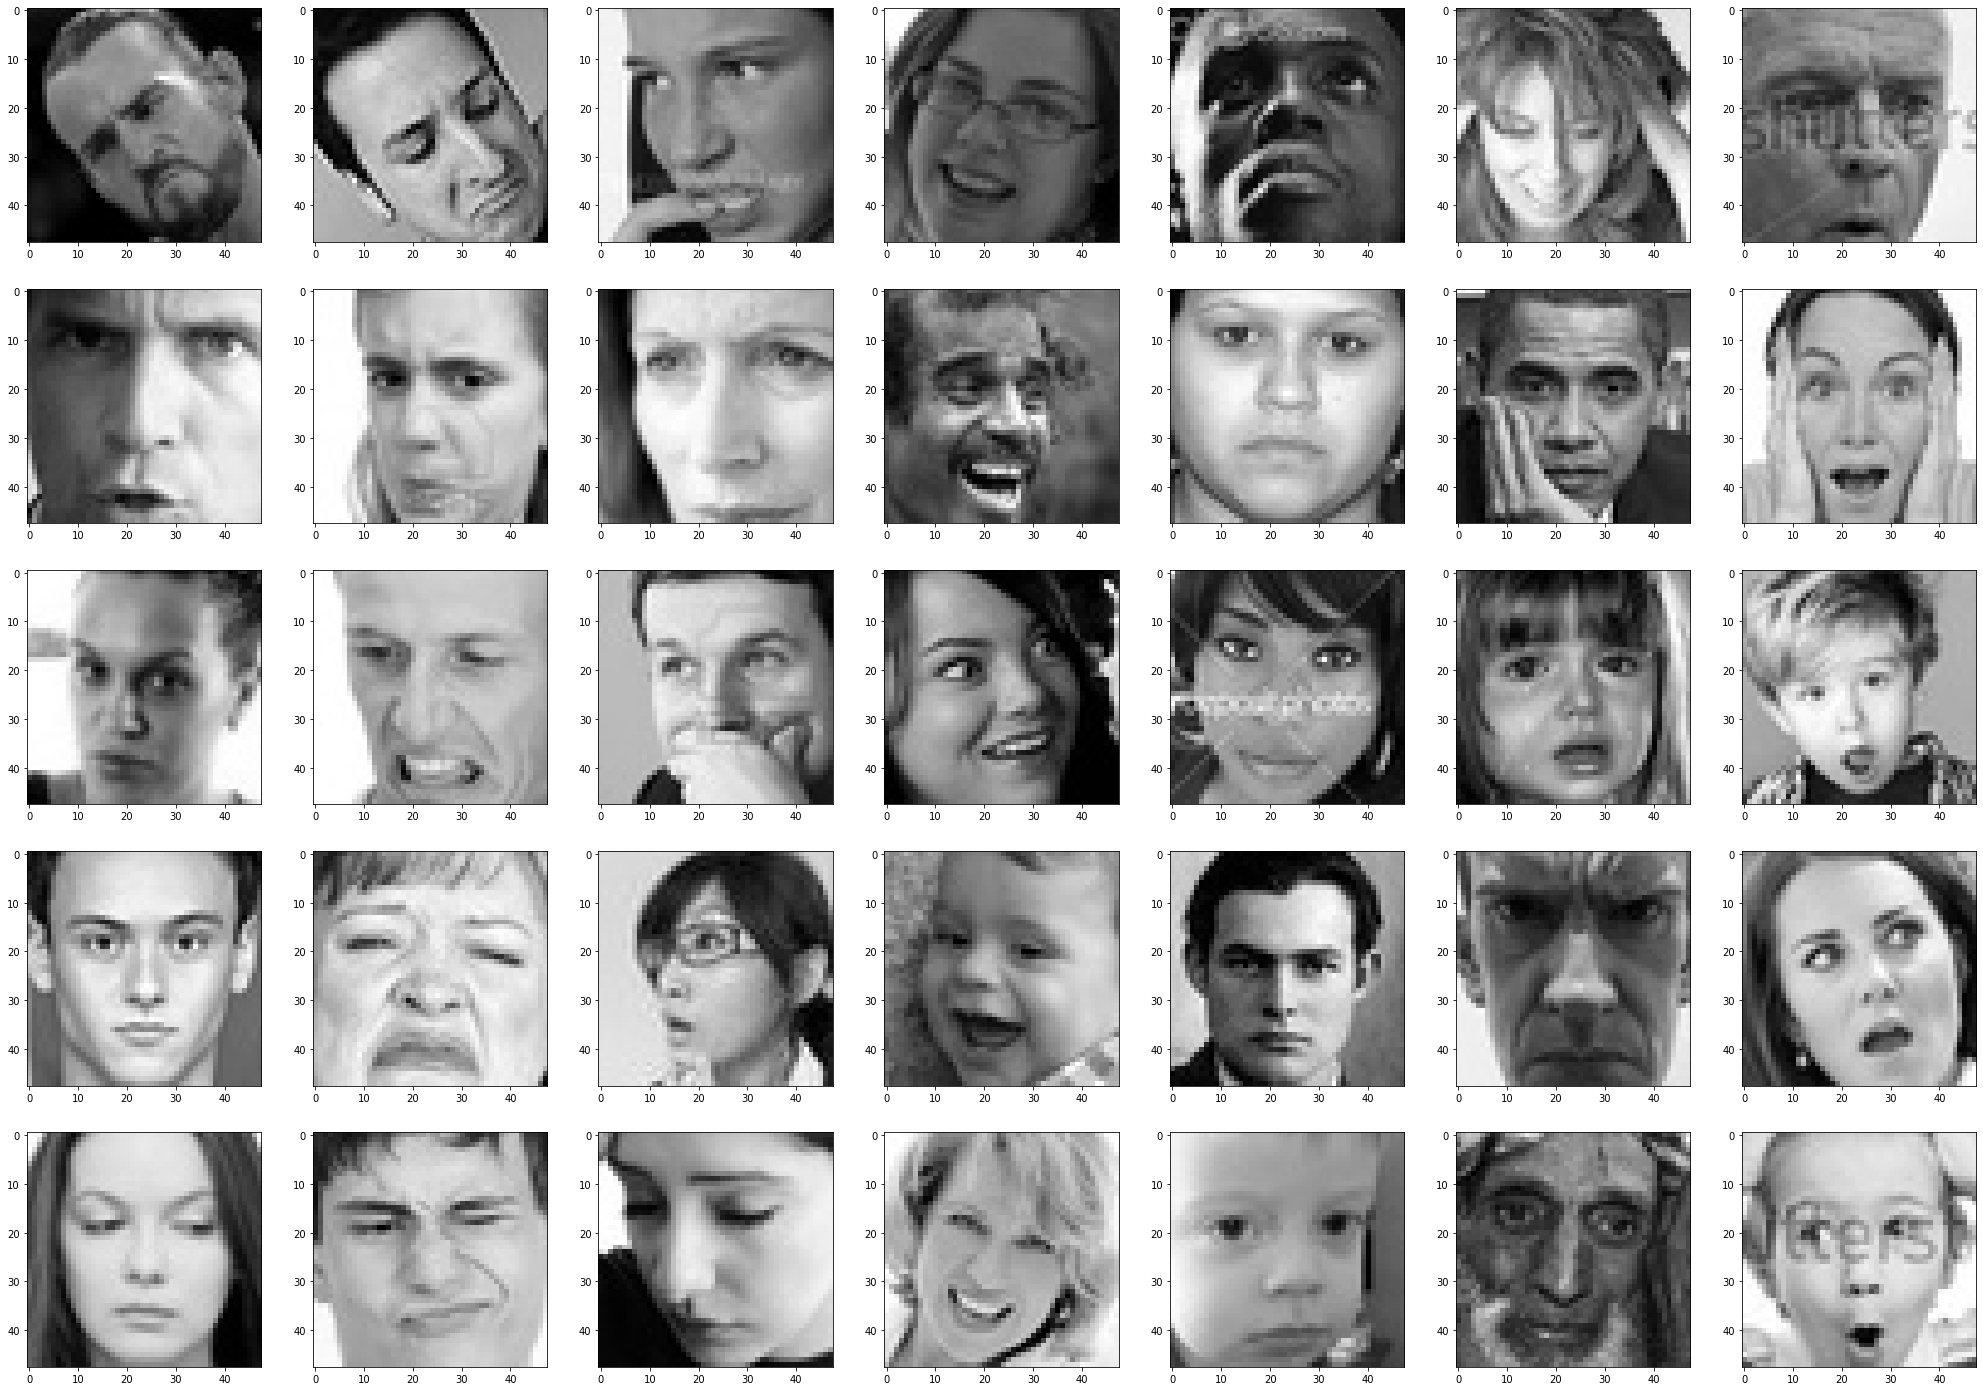

In [13]:
# Data Visualization
from skimage.io import imread
train_dir = "train/"
test_dir = "test/"
total_labels = len(os.listdir(train_dir))

fig, ax = plt.subplots(nrows=5, ncols=total_labels, figsize=(35, 25))
for x in range(5):
    for y,v in zip(range(total_labels),os.listdir(train_dir)):
        ax[x][y].imshow(imread(train_dir+v+'/'+os.listdir(train_dir+v)[x]), cmap='gray')

plt.show()

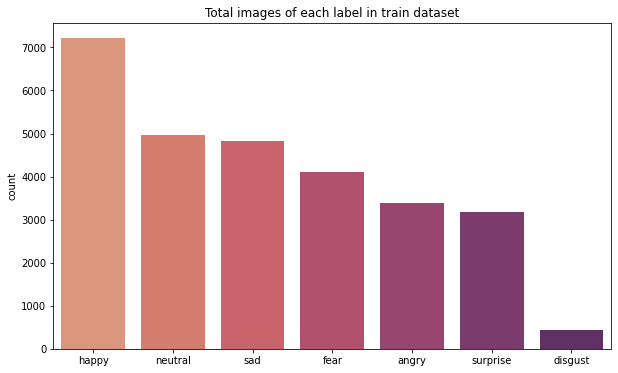

In [14]:
df = {}
for i in os.listdir(train_dir):
    directory = train_dir + i
    df[i] = len(os.listdir(directory))
df = pd.DataFrame(df, index=["total"]).transpose().sort_values("total", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=df.index, y="total", palette="flare", data=df)
plt.ylabel("count")
plt.title("Total images of each label in train dataset")
plt.show()


C:\Users\sbpat\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


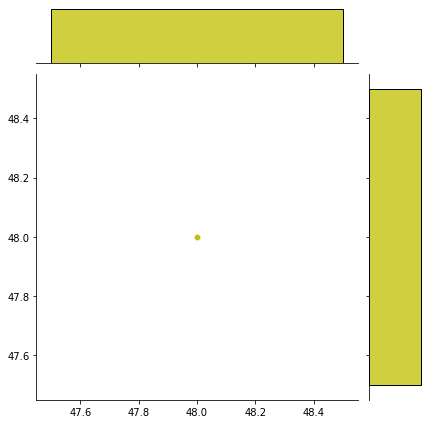

In [15]:
happy = os.listdir(train_dir+'happy/')
dim1, dim2 = [], []

for img_filename in happy:
    img = imread(train_dir+'happy/'+img_filename)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)
sns.jointplot(dim1, dim2,color='y')
plt.show()

In [16]:
# Data Preprocessing
train_gen = ImageDataGenerator(rescale=1/255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1/255)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)

train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_gen.flow_from_directory(directory=test_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=False)


Found 28111 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Creating the Model

In [17]:
# Create the Model
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=len(os.listdir(train_dir)), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)      5

# Training the model


In [18]:
# Train the model
model.compile(optimizer=Adam(learning_rate=0.0001, 
                             decay=1e-6), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [19]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size
num_epochs = 20

history = model.fit(train_generator,
                    epochs=num_epochs,
                    verbose=1,
                    #callbacks=callbacks,
                    validation_data=test_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/20
439/439 [==============================] - 1666s 4s/step - loss: 1.8728 - accuracy: 0.2377 - val_loss: 2.4440 - val_accuracy: 0.2479
Epoch 2/20
439/439 [==============================] - 1669s 4s/step - loss: 1.7967 - accuracy: 0.2564 - val_loss: 1.7875 - val_accuracy: 0.2679
Epoch 3/20
439/439 [==============================] - 1725s 4s/step - loss: 1.7828 - accuracy: 0.2593 - val_loss: 1.7192 - val_accuracy: 0.2916
Epoch 4/20
439/439 [==============================] - 1613s 4s/step - loss: 1.7722 - accuracy: 0.2663 - val_loss: 1.7713 - val_accuracy: 0.2949
Epoch 5/20
439/439 [==============================] - 1241s 3s/step - loss: 1.7545 - accuracy: 0.2841 - val_loss: 1.7139 - val_accuracy: 0.3083
Epoch 6/20
439/439 [==============================] - 1166s 3s/step - loss: 1.7321 - accuracy: 0.2978 - val_loss: 1.7304 - val_accuracy: 0.3225
Epoch 7/20
439/439 [==============================] - 1177s 3s/step - loss: 1.7065 - accuracy: 0.3117 - val_loss: 1.5907 - val_accuracy:

# Saving the trained model

In [37]:
model.save("model.h5")


# Evaluate the model

In [38]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)

113/113 [==============================] - 63s 561ms/step - loss: 1.2417 - accuracy: 0.5157
validation accuracy : 51.57425403594971%
validation loss : 1.241727352142334


# Plotting Training and Validation plot


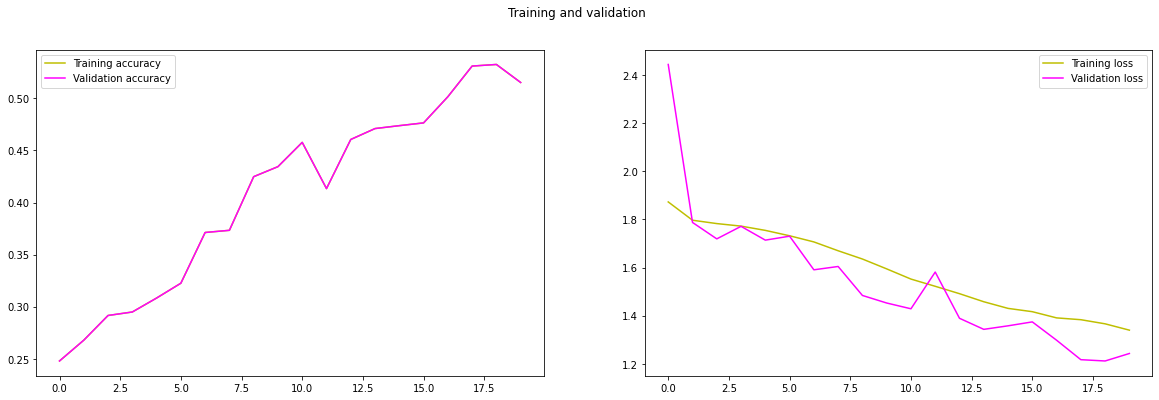

In [39]:
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(val_acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, val_acc, 'y', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'magenta', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'y', label='Training loss')
ax[1].plot(epochs, val_loss, 'magenta', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

# Plotting the confusion matrix


C:\Users\sbpat\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sbpat\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sbpat\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

       angry       0.36      0.51      0.42       958
     disgust       0.00      0.00      0.00       111
        fear       0.37      0.13      0.20      1024
       happy       0.80      0.76      0.78      1774
     neutral       0.39      0.68      0.49      1233
         sad       0.46      0.23      0.31      1247
    surprise       0.62      0.73      0.67       831

    accuracy                           0.52      7178
   macro avg       0.43      0.43      0.41      7178
weighted avg       0.52      0.52      0.49      7178





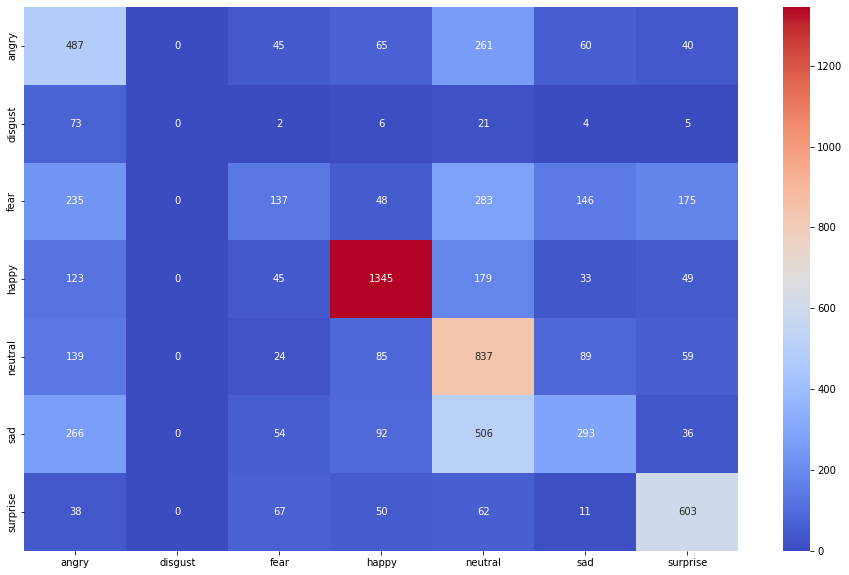

In [40]:
# confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(test_generator), axis=-1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()), end='\n\n\n')

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(16,10))
sns.heatmap(cm, cmap=plt.cm.coolwarm, annot=True, fmt='.0f', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()

# Testing our model with new image


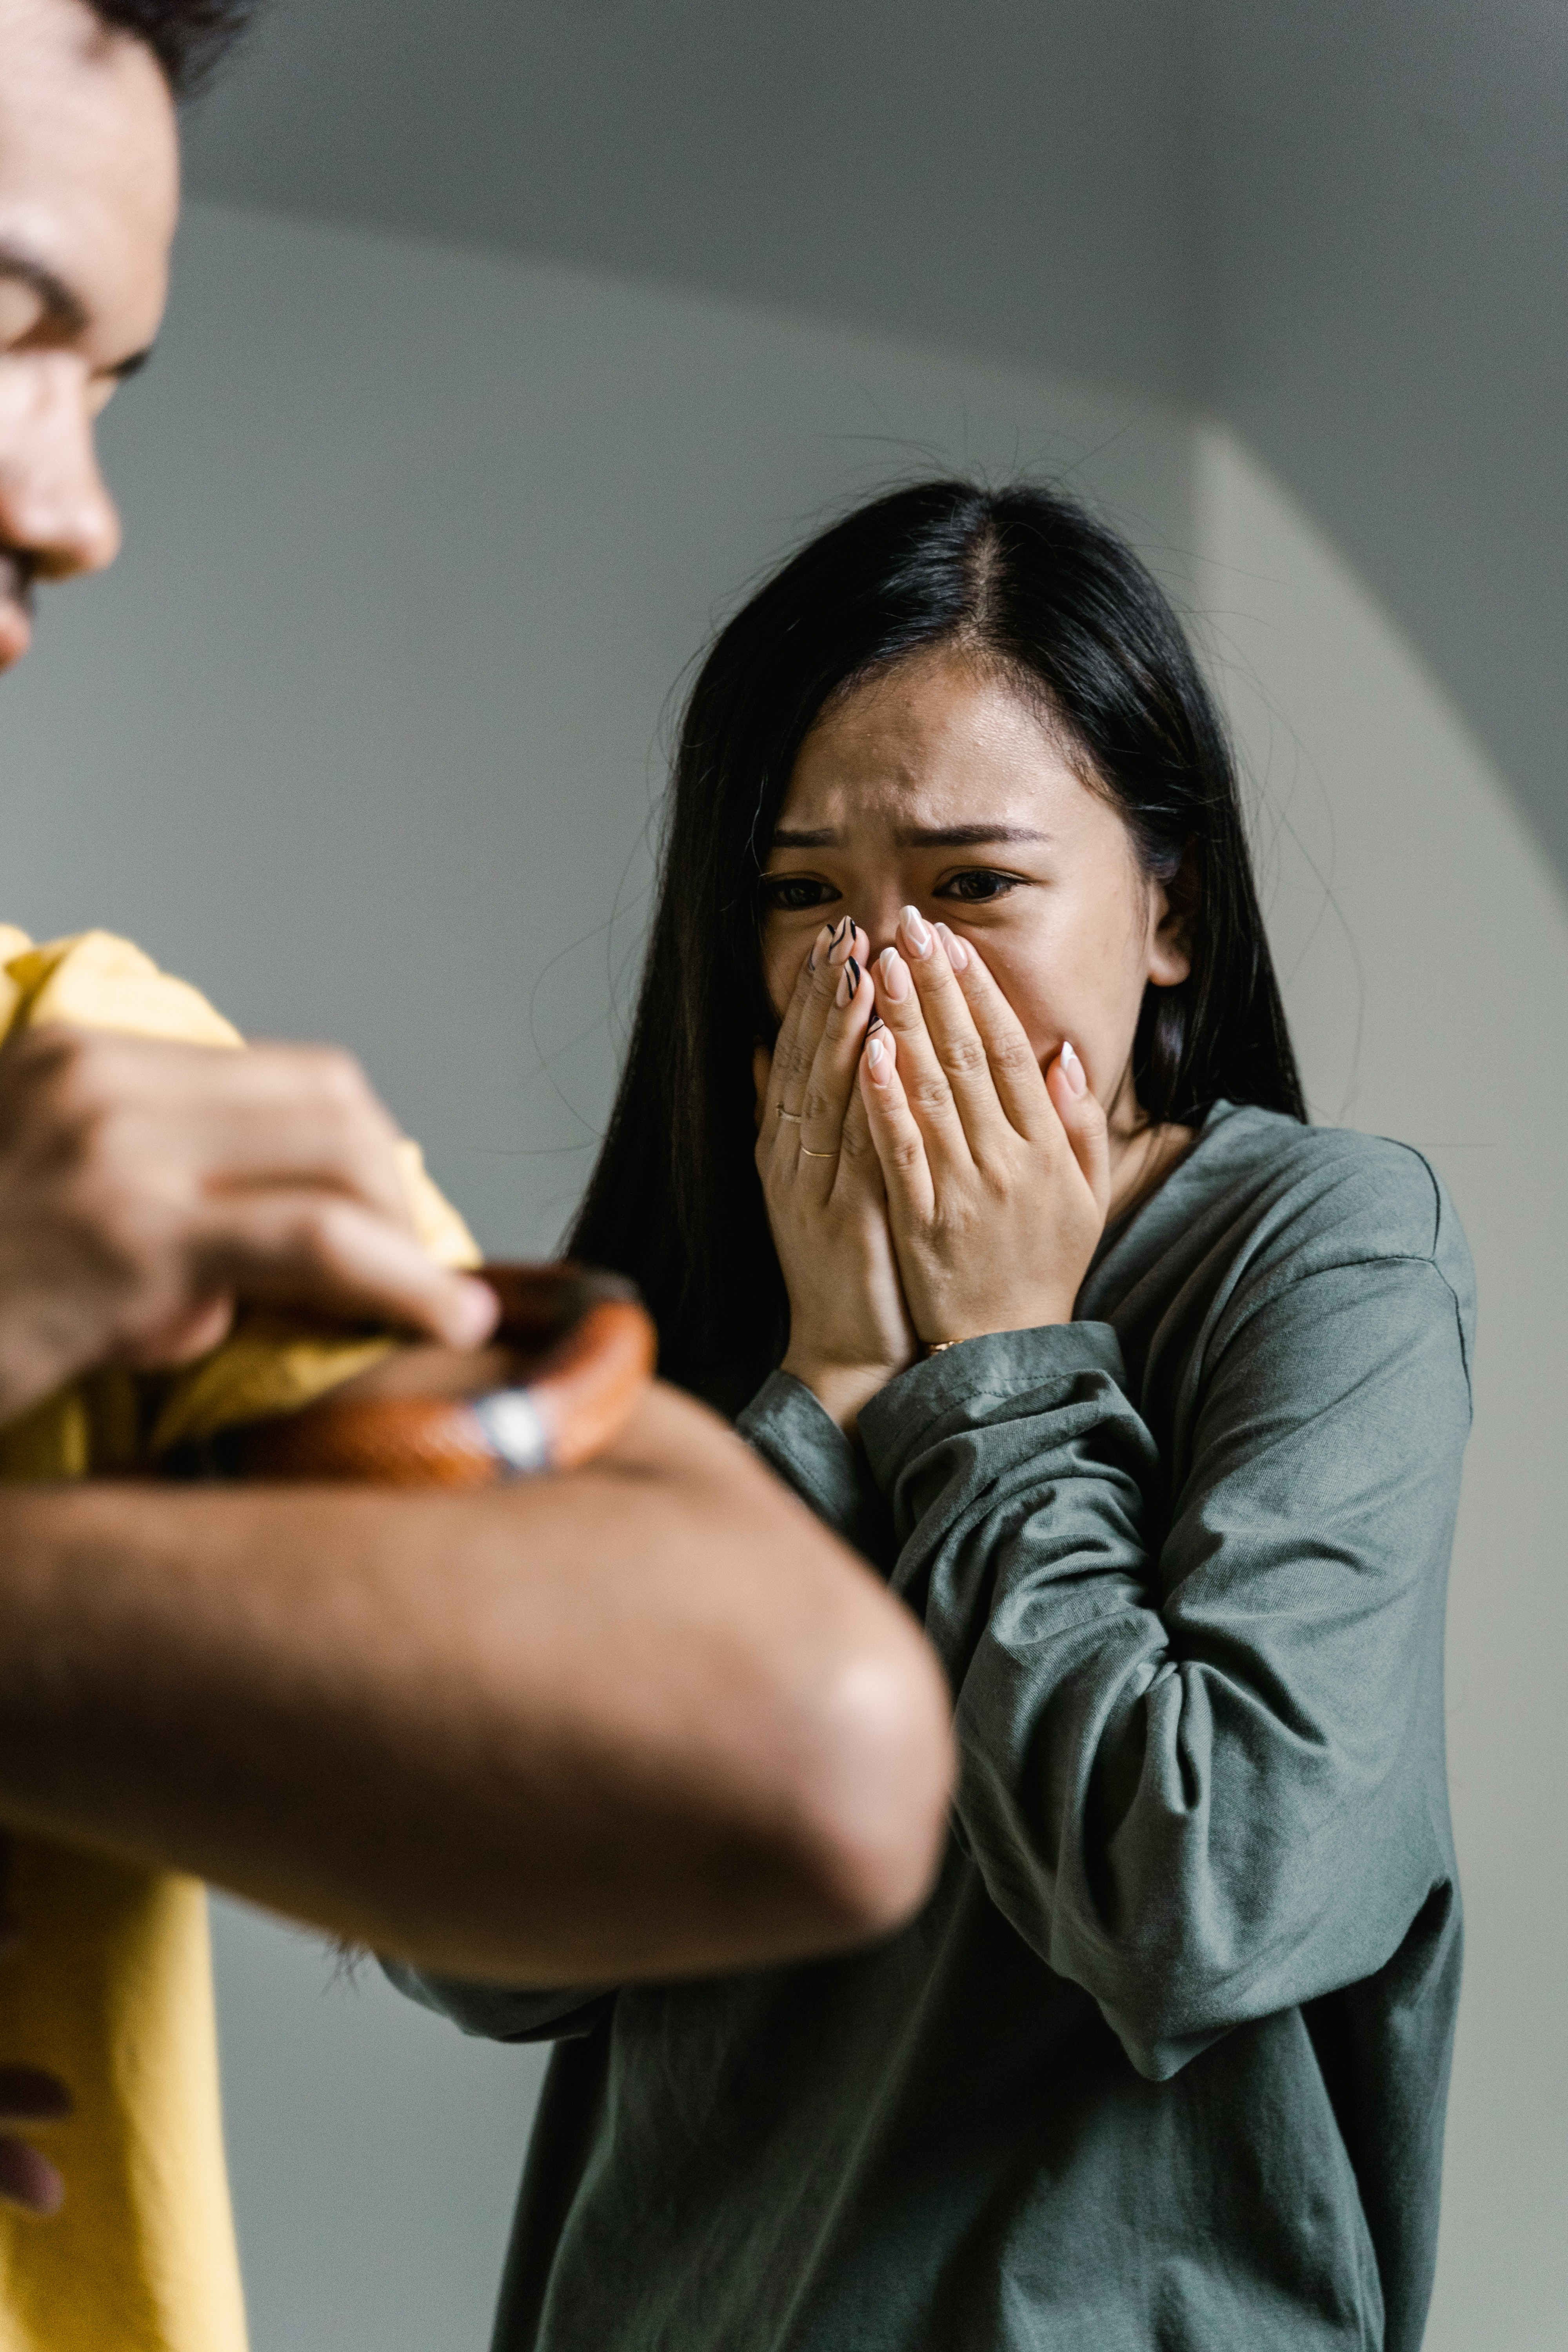

In [41]:
# Testing our model with new image
image = cv2.imread("images/Sad.jpg")
from IPython.display import Image
Image(filename='Sad.jpg')

# Model Prediction


In [ ]:
# Model Prediction
import cv2
from tensorflow.python.keras.models import load_model
import os


# # load the trained model
model = load_model("model.h5")
# A list of emoticon categories
EMOTIONS = ['Angry', 'Disgust', 'Happy', 'Sad', 'Surprise', 'Neutral']
# Load image
img = image

# Trim the image to 48 x 48, and turn the grayscale image, normalization
frame = cv2.resize(img,(48,48),interpolation=cv2.INTER_BITS2)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0

# Reinvent the image dimension
gray = gray.reshape(1,48,48,1)

# Output the prediction
predicts = model.predict(gray)[0]
label = EMOTIONS[predicts.argmax()]
for (i,j) in zip(range(7),EMOTIONS):
    predictss = predicts[i]
    print("{:^10s}".format(j)+"prediction rate is   {0:.2f}%".format(predictss))
print( "\n\n The system considers this expression to be:",label)


  Angry   prediction rate is   0.24%
 
 Disgust  prediction rate is   0.00%
  
  Happy   prediction rate is   0.08%
   
   Sad    prediction rate is   0.27%
 
 Surprise prediction rate is   0.26%
 
 Neutral  prediction rate is   0.10%


 The system considers this expression to be: Sad

# Song Recommdation


In [ ]:
# Song Recommdation
if (label=='Angry'):
    path="test\\Angry\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='song\\Angry\\'+ d,autoplay=True)
    display(audio)
    
elif (label=='Disgust'):
    path="test\\Disgust\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='song\\Disgust\\'+ d,autoplay=True)
    display(audio)
    
elif (label=="Happy"):
    path="test\\happy\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='song\\Happy\\'+ d,autoplay=True)
    display(audio)
    
elif (label=='Sad'):
    path="test//sad//"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='song\\Sad\\'+ d,autoplay=True)
    display(audio)
elif (label=='Surprise'):
    path="test\\Surprise\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='song\\Surprise\\'+ d,autoplay=True)
    display(audio)
    
elif (label=='Neutral'):
    path="test\\Neutral\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='song\\Neutral\\'+ d,autoplay=True)
    display(audio)


Now Playing: English Sad Song Slow Music heart touching painful.mp3


In [48]:
label="Sad"